## Objective
Plot a histogram of 5 RMS of sliding window of recording

In [64]:
%load_ext autoreload
%autoreload

# from importlib import reload
# from src import plot
# reload(plot)
# from src.plot import plot_hist_percents

# Update PATH to allow imports
import sys
sys.path.append("/data/MEAprojects/DLSpikeSorter")

# Imports
from spikeinterface.extractors import NwbRecordingExtractor, MaxwellRecordingExtractor
from spikeinterface.preprocessing import highpass_filter, bandpass_filter, scale
import numpy as np
from pathlib import Path
from tqdm import tqdm
from multiprocessing import Pool
import matplotlib.pyplot as plt
from src.plot import set_dpi, plot_hist_percents

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
class GetChunkCrossingsWrapper:
    """
    Wrapper class for func in multiprocessing for getting noises

    The bottleneck for getting noises is get_traces, so this is what is being parallel processed
    """

    def __init__(self, rec_path, freq_min, freq_max, chunk_size):
        self.rec_path = rec_path
        self.freq_min = freq_min
        self.freq_max = freq_max
        self.chunk_size = chunk_size

    def __call__(self, start_frame):
        rec_path = self.rec_path
        if rec_path.suffix == ".h5":
            rec = MaxwellRecordingExtractor(rec_path)
        else:
            rec = NwbRecordingExtractor(rec_path)
        rec = scale(rec, rec.get_channel_gains(), rec.get_channel_offsets())
        if self.freq_max >= rec.get_sampling_frequency() / 2:
            # The frequency of a constituent signal must be less than the sampling_frequency / 2
            rec = highpass_filter(rec, freq_min=self.freq_min, dtype="float32")  # type: NwbRecordingExtractor
        else:
            rec = bandpass_filter(rec, freq_min=self.freq_min, freq_max=self.freq_max, dtype="float32")  # type: NwbRecordingExtractor

        traces_all = rec.get_traces(start_frame=start_frame, end_frame=start_frame + self.chunk_size, return_scaled=False)

        return np.sqrt(np.mean(traces_all**2, axis=0))


def save_noises(save_path, rec_path, freq_min=300, freq_max=3000, chunk_size=1000):
    """
    Save noise (RMS) values of sliding window across recording

    :param save_path:
        Path to save .npy data
    :param rec_path:
        Path to .h5 file from Maxwell Biosystems or .nwb file containing data
    :param freq_min:
        In Hz, filter LFP between (freq_min, freq_max)
    :param freq_max:
        In Hz, filter LFP between (freq_min, freq_max)
    :param chunk_size:
    """

    rec_path = Path(rec_path)
    if rec_path.suffix == ".h5":
        rec = MaxwellRecordingExtractor(rec_path)
    else:
        rec = NwbRecordingExtractor(rec_path)

    noises = []
    with Pool(processes=16) as pool:
        tasks = range(0, rec.get_total_samples(), chunk_size)
        for n in tqdm(pool.imap(GetChunkCrossingsWrapper(rec_path, freq_min, freq_max, chunk_size), tasks, len(tasks) // 40), total=len(tasks)):
            noises.extend(n)

    np.save(save_path, noises)

In [11]:
# Paths to noise save files
RECORDINGS = ["2950", "2953", "2954", "2957", "5116", "5118"]
REC_PATH_ROOT = "/data/MEAprojects/DLSpikeSorter/{}/data.raw.h5"
SAVE_PATH_ROOT = "/data/MEAprojects/DLSpikeSorter/{}/window_rms.npy"

In [15]:
# Save noises of recordings --> Don't run if they have already been saved!
##
for rec in RECORDINGS:
    save_noises(SAVE_PATH_ROOT.format(rec), REC_PATH_ROOT.format(rec),
                freq_min=300, freq_max=3000, chunk_size=1000)

100%|██████████| 3602/3602 [00:51<00:00, 69.75it/s] 


In [16]:
# Load noises
noises = []
for rec in RECORDINGS:
    noises.extend(np.load(SAVE_PATH_ROOT.format(rec)))

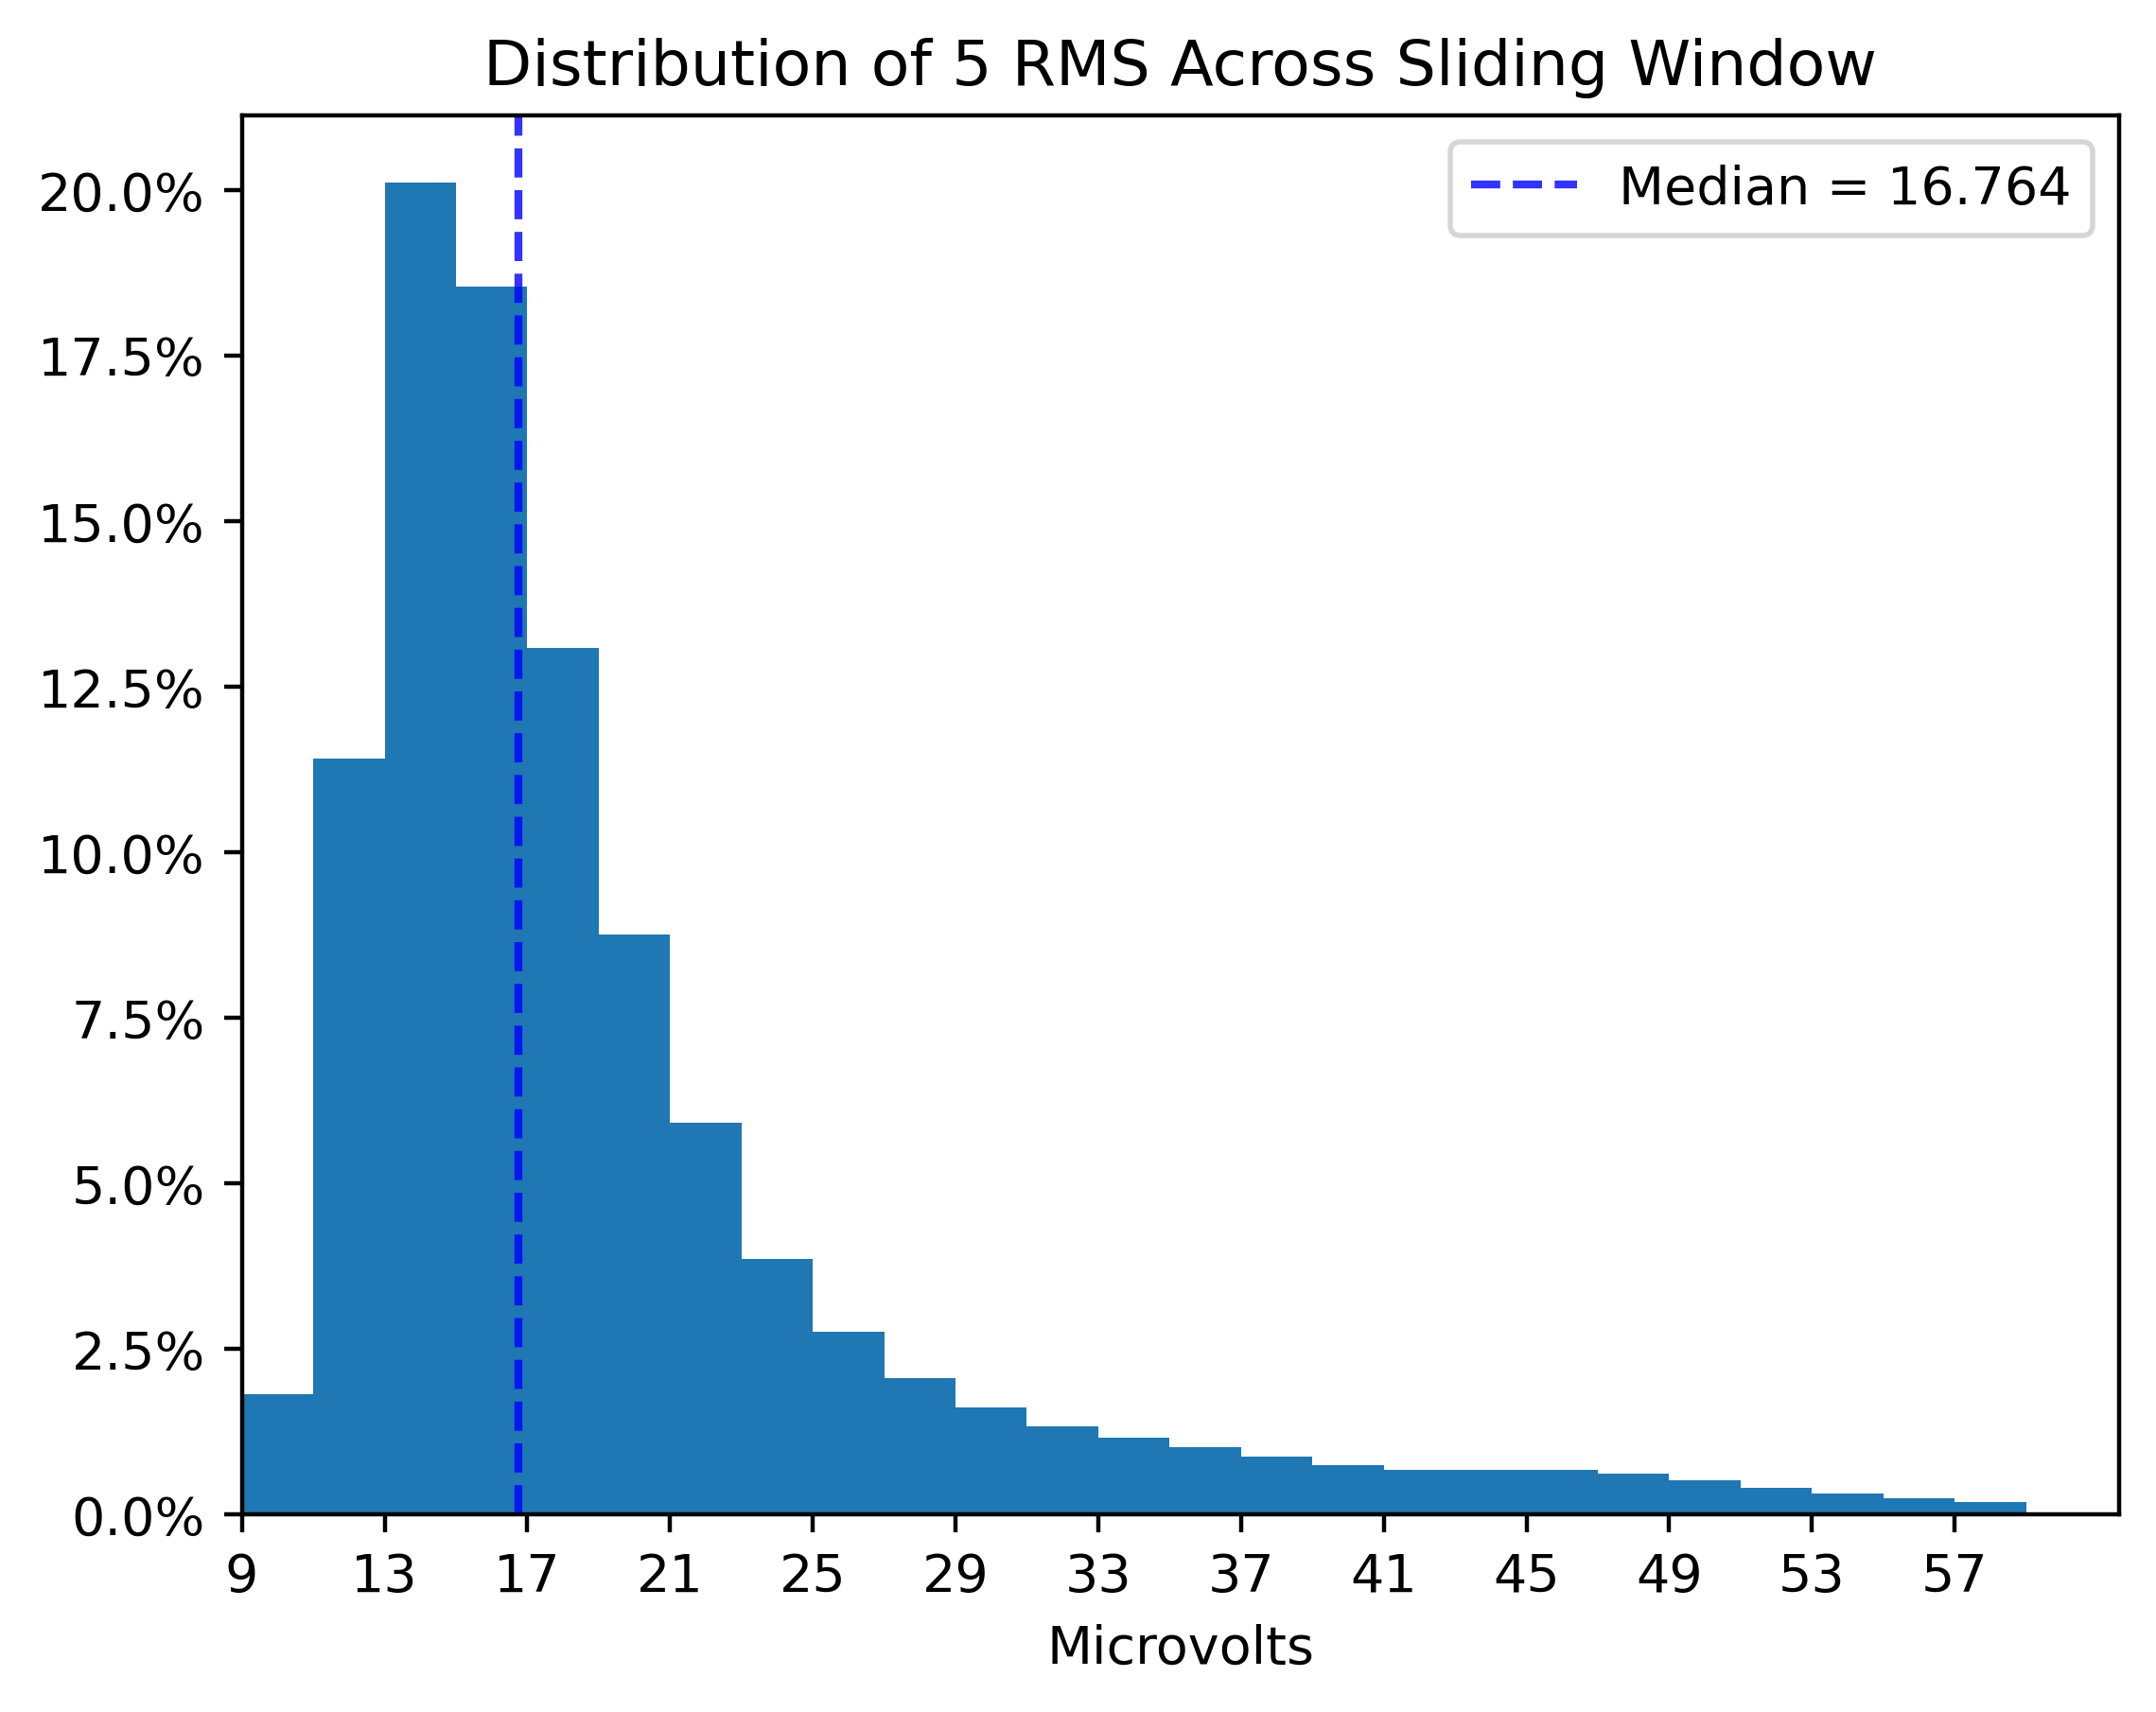

In [63]:
N_BINS = 26
X_MAX = 60
set_dpi(400)
##
# Plot noises
noises_5 = np.array(noises) * 5
median = np.median(noises_5)
x_min = np.min(noises_5)
bins = range(int(x_min), X_MAX, (X_MAX - int(x_min)) // N_BINS)

plt.title("Distribution of 5 RMS Across Sliding Window")
plot_hist_percents(noises_5, range=(x_min, X_MAX), bins=bins)
plt.axvline(median, c="blue", linestyle="dashed", alpha=0.8, label=f"Median = {median:.3f}")
plt.xlabel("Microvolts")
plt.xticks(bins[1::2])
plt.xlim(bins[1])
plt.legend()
plt.show()

In [49]:
median

16.764023